# Parameter estimation of the Hodgkin-Huxley model by using EfficientNet
#### $\begin{equation*}I_{Kr}=g_{Kr}ar(V-E_K)\end{equation*}$
#### Estimating 9 Parameters : $[g_{Kr},\ p_1,\ p_2,\ p_3,\ p_4,\ p_5,\ p_6,\ p_7,\ p_8]$

In [1]:
import os, sys, copy, time
sys.path.append('../')
sys.path.append('./')

import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torchaudio.transforms as AT
from torch.utils.data import  Dataset, TensorDataset, DataLoader
# from efficientnet_pytorch import EfficientNet

#from parallel import DataParallelModel, DataParallelCriterion

from typing import Type, Any, Callable, Union, List, Optional
from IPython.display import HTML
from IPython import display
from datetime import datetime
import pandas as pd
import seaborn as sns
import librosa.display
import cv2
import skimage.io

from tqdm import tqdm

sys.path.append('../../JKLib')
from pythonJK import create_folder
from torchJK import CosineAnnealingWarmUpRestarts, PositionalEncoding

# seed 값 생성
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

1.10.2+cu113


In [2]:
dataset_name = "ohara2017_leemV1_w10_s5"
dataset_dir = f'../../Dataset/{dataset_name}'
sys.path.append(dataset_dir)
from agetdata import get_dataset
from model0 import TransformerION

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
device

Multi GPU activate


device(type='cuda')

In [4]:
BATCH_SIZE = 7000
EPOCHS = 700
print_every = 1

train_dataset_li = list(range(1, 21))
val_dataset_li = list(range(21, 26))
model_save_dir = f"./trained_model0_{dataset_name}"
existing_model_path = os.path.join(model_save_dir, 'params-168.pk')

# Parameters for trained_model1
d_model = 512    # default : 512
nhead = 8    # default : 8
num_encoder_layers = 3  # default : 6
dim_feedforward = 2048   # default : 2048
n_parameters = 7

patience = 1000

create_folder(model_save_dir)        

"./trained_model0_ohara2017_leemV1_w10_s5" has been created.


In [5]:
'''
Load time, Christini Voltage Calmp ,currents and parameters
'''
start_time = time.time()
x_val, y_val = get_dataset( val_dataset_li, multi=False, use_torch=True )
x_val = x_val.type(torch.float)
y_val = y_val.type(torch.float)
print(x_val.shape, y_val.shape)
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.5050594806671143 seconds ---
torch.Size([50000, 7, 263]) torch.Size([50000, 7])
--- 0.7345528602600098 seconds ---


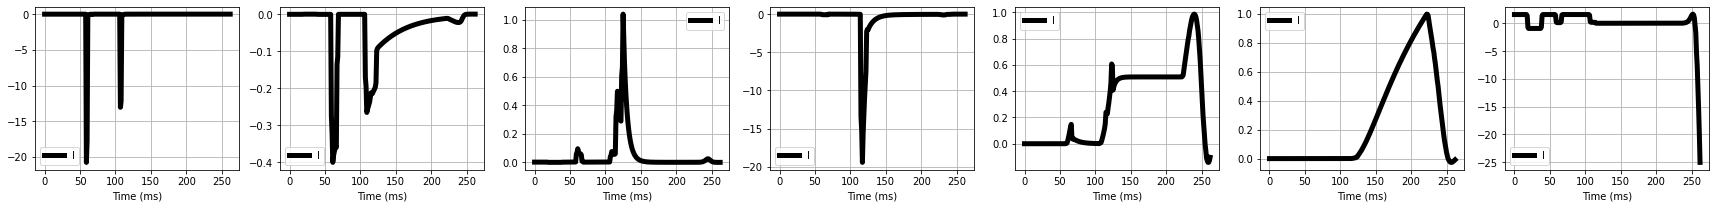

In [5]:
'''
Plot
'''
currents = x_val[0]

fig, ax = plt.subplots(1,7, figsize=(30,3))    
# fig.suptitle(sim.name, fontsize=14)
axNo = 0
for i, val in enumerate(currents):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[axNo].set_xlabel('Time (ms)')       
    # ax[axNo].set_ylabel(f'{name}')      
    ax[axNo].plot( val, label='I', color='k', linewidth=5)             
    ax[axNo].legend()
    ax[axNo].grid()
    axNo += 1

# ax[-1].set_ylim(-5, 5)
# plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)

In [6]:
from torch.utils.data import  TensorDataset, DataLoader
val_ds = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
print(val_ds[0][0].shape, val_ds[0][1].shape)

torch.Size([7, 263]) torch.Size([7])


In [8]:
# model = TransformerION(num_encoder_layers = 2,
#                        d_model = 512,
#                        nhead = 8,
#                        dim_feedforward = 2048,
#                        n_parameters = 7)

# src = torch.rand((10, 7, 263))
# print(src.type())
# # if torch.cuda.device_count() > 1:
# #     model = nn.DataParallel(model, device_ids=[0,1])
# model.to(device)
# model(src.to(device)).size()

In [9]:
model = TransformerION(num_encoder_layers = num_encoder_layers,
                       d_model = d_model,
                       nhead = nhead,
                       dim_feedforward = dim_feedforward,
                       n_parameters = n_parameters
                      )


checkpoint = None

load_model = True
if load_model:
    try:
        #model = torch.load(os.path.join(model_save_dir, 'saved_model-10.pk'))
        checkpoint = torch.load(existing_model_path) 
        model.load_state_dict(checkpoint['model_state_dict'])
        print("The model has been loaded.")
         
    except:
        print("There are no models.")
        load_model = False
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0,1])
model.to(device)

print("-"*50)

There are no models.
--------------------------------------------------


100 0.000944953402828342
200 0.0005650634295466716
300 0.00012896707842543898
400 0.0009866048747930191
500 0.0006818132283403234
600 0.00021995849622602
700 2.3359828520641556e-08


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust

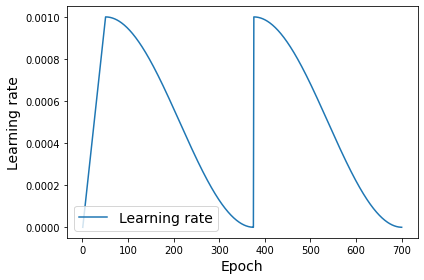

In [10]:
import transformers

#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, betas=(0.9, 0.98), eps=1e-09)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)                    
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001, last_epoch=-1, verbose=False)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=0.000001, last_epoch=-1, verbose=False)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=400, T_mult=1, eta_max=0.0001, T_up=50, gamma=1.0)
optimizer = transformers.AdamW(model.parameters(), lr=0.001)
scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=700, num_cycles=2, last_epoch=-1)

epoch_li = []
lr_li = []
last_epoch = 10
for epoch in range(1, last_epoch+1):
    lr = scheduler.get_lr()[0]    
    epoch_li.append(epoch)
    lr_li.append(lr)
    scheduler.step(epoch)        
#     print(epoch, lr)
for epoch in range(last_epoch+1, 701):
    
    lr = scheduler.get_lr()[0]        
    epoch_li.append(epoch)
    lr_li.append(lr)

    scheduler.step(epoch)        
    if epoch%100==0 :
        print(epoch, lr)

# plt.title("Learning rate", fontsize=18) 
plt.plot( epoch_li, lr_li, label='Learning rate')
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Learning rate", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( 'learning-rate.jpg', dpi=199) 
plt.show()

In [11]:
def evaluate(model, data_loader): 
    loss_sum = 0    
    criterion = nn.MSELoss()
    nIter = 0
    with torch.no_grad(): 
        model.eval()   
        for i, data in enumerate(data_loader):
            output = model(data[0].cuda())            
            loss = criterion(output, data[1].cuda())
            loss_sum += loss   
            nIter+=1            
    model.train()
    return loss_sum.item()/nIter


def train(train_loader, val_loader, optimizer, scheduler ):
    print("Learning start...")
    train_start = time.time()
        
    criterion = nn.MSELoss()
    
    epoch_start = 1    
    train_loss_li = []
    val_loss_li = []    
    time_taken = 0.0    
    best_train_losses = np.ones(10)*float('inf')
    best_val_losses = np.ones(10)*float('inf')
            
    if load_model:
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']+1             
        train_loss_li = checkpoint['train_loss_li']
        val_loss_li = checkpoint['val_loss_li']
        best_train_losses = np.sort(np.array(train_loss_li))[:10]
        best_val_losses = np.sort(np.array(val_loss_li))[:10]
        time_taken = checkpoint['time']
        print('start epoch : %d'%(epoch_start))
        print('best train loss : %f'%(best_train_losses.min()))
        print('best val loss : %f'%(best_val_losses.min()))
        print("="*50)
    
    for epoch in range(1, epoch_start):
        lr = scheduler.get_lr()[0]            
        scheduler.step(epoch)   

    patience_iter = 0
    #sigmoid = nn.Sigmoid()
    for epoch in range(epoch_start, EPOCHS+1):
        epoch_start = time.time()
        print("Epoch %d start.-------------------------------------------"%(epoch))
        
        #best_model_weights = copy.deepcopy(model.state_dict())
        #best_accuracy = 0.0        
        
        nIter = 0
        train_loss = 0
        model.train()         
        
        for i, (inputs, targets) in enumerate(tqdm(train_loader)):
            # print(inputs.size())
            # print(targets.type())

            optimizer.zero_grad()                        
            output = model(inputs.to(device))   
            # print(output.size())
            #output = sigmoid(output)   
            loss = criterion(output, targets.to(device))        
            
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()        
            train_loss += loss
            nIter+=1

        train_loss = train_loss.item()/nIter
        val_loss = evaluate(model, val_loader)
                
        train_loss_li.append(train_loss)            
        val_loss_li.append(val_loss)
        
#         train_best1 = best_train_losses.min()
#         train_best10 = best_train_losses.max()
        val_best1 = best_val_losses.min()
        val_best10 = best_val_losses.max()
        
#         if ( epoch % print_every==0  ) :    
        if val_loss<val_best10 or (epoch==EPOCHS) or (epoch%50==0): 
            model_to_be_saved = model
            if torch.cuda.device_count() > 1:     
                model_to_be_saved = model.module  

            save_param_path = os.path.join(model_save_dir, "params-" + str(epoch) + '.pk')                  
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_to_be_saved.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),                        
                    'train_loss_li': train_loss_li, 
                    'val_loss_li' : val_loss_li,
                    'time' : (time_taken + time.time() - train_start)
                    }, save_param_path)
            #save_model_path = os.path.join(model_save_dir, "model-" + str(epoch) + '.pk')  
            #torch.save(model_to_be_saved, save_model_path)                                          
            
            if (val_loss <= val_best10) :
                best_val_losses[np.argmax(best_val_losses)] = val_loss

            if (val_loss <= val_best1) :
                patience_iter=0
                print( "The best val loss improved from %f to %f"%(val_best1, val_loss))
            else:
                patience_iter+=1

        else:
            patience_iter+=1
            print("val_loss did not improve from %f"%(best_val_losses.min()))
        
        if patience_iter>=patience:
            break
        
        print("=> mse : %f | val_loss : %f | lr : %e -  %fs"%( train_loss, val_loss, scheduler.get_lr()[0], (time.time() - epoch_start)))
        print("=> Time spent : %fs"%( time_taken + time.time() - train_start ) )
        print("-"*50)
        
        # Update learning rate
        scheduler.step(epoch)
        
        if (epoch % 10==0):
            display.clear_output(wait=True)

In [12]:
start_time = time.time()
x_train, y_train = get_dataset( train_dataset_li, multi=False, use_torch=True )
x_train = x_train.type(torch.float)
y_train = y_train.type(torch.float)
print(x_train.shape, y_train.shape)
print("--- %s seconds ---"%(time.time()-start_time))

--- 1.7800474166870117 seconds ---
torch.Size([200000, 7, 263]) torch.Size([200000, 7])
--- 2.4547789096832275 seconds ---


In [13]:
train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [ ]:
start_time = time.time()
train(train_loader, val_loader, optimizer, scheduler)
print("--- %s seconds ---"%(time.time()-start_time))

Learning start...
Epoch 1 start.-------------------------------------------


 45%|███████████████████▎                       | 13/29 [00:13<00:09,  1.67it/s]

In [ ]:
print("Training complete")